## 1. Load datasets, Libraries, and prepare for analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
from scipy.fft import fft
from scipy.fft import rfft
from scipy.stats import entropy
import umap

c:\Users\icaro\anaconda3\envs\esa-anomaly-challenge_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\icaro\anaconda3\envs\esa-anomaly-challenge_env\Lib\site-packages\umap\__init__.py:36: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
df_train = pd.read_parquet('train.parquet', engine='pyarrow')
df_test = pd.read_parquet('test.parquet', engine='pyarrow')

In [3]:
list(df_train.columns.values)

['id',
 'channel_1',
 'channel_10',
 'channel_11',
 'channel_12',
 'channel_13',
 'channel_14',
 'channel_15',
 'channel_16',
 'channel_17',
 'channel_18',
 'channel_19',
 'channel_2',
 'channel_20',
 'channel_21',
 'channel_22',
 'channel_23',
 'channel_24',
 'channel_25',
 'channel_26',
 'channel_27',
 'channel_28',
 'channel_29',
 'channel_3',
 'channel_30',
 'channel_31',
 'channel_32',
 'channel_33',
 'channel_34',
 'channel_35',
 'channel_36',
 'channel_37',
 'channel_38',
 'channel_39',
 'channel_4',
 'channel_40',
 'channel_41',
 'channel_42',
 'channel_43',
 'channel_44',
 'channel_45',
 'channel_46',
 'channel_47',
 'channel_48',
 'channel_49',
 'channel_5',
 'channel_50',
 'channel_51',
 'channel_52',
 'channel_53',
 'channel_54',
 'channel_55',
 'channel_56',
 'channel_57',
 'channel_58',
 'channel_59',
 'channel_6',
 'channel_60',
 'channel_61',
 'channel_62',
 'channel_63',
 'channel_64',
 'channel_65',
 'channel_66',
 'channel_67',
 'channel_68',
 'channel_69',
 'channel

In [4]:
# df_train.describe()

In [5]:
# From the original dataset description, The subset of 6 channels 41-46 is recommended as a
# good starting point for developing and testing algorithms before applying them to the full set.

df_train_4146 = df_train[['id', 'channel_41', 'channel_42', 'channel_43', 'channel_44', 'channel_45', 'channel_46', 'is_anomaly']].copy()
df_train_4146

,id,channel_41,channel_42,channel_43,channel_44,channel_45,channel_46,is_anomaly
0,0,0.812578,0.786344,0.771900,0.799178,0.816855,0.765296,0
1,1,0.812578,0.786344,0.771900,0.799178,0.816855,0.765296,0
2,2,0.821213,0.789557,0.770317,0.809411,0.816006,0.765296,0
3,3,0.819642,0.786344,0.770317,0.807050,0.816855,0.766985,0
4,4,0.821996,0.788753,0.770317,0.807837,0.818551,0.761073,0
...,...,...,...,...,...,...,...,...
14728316,14728316,0.806299,0.799999,0.767944,0.792093,0.821094,0.752628,0
14728317,14728317,0.806299,0.790360,0.765569,0.792881,0.821941,0.763607,0
14728318,14728318,0.806299,0.795180,0.765569,0.792881,0.822790,0.762762,0
14728319,14728319,0.806299,0.796786,0.767152,0.796816,0.820247,0.761073,0


In [6]:
num_anomaly = df_train_4146['is_anomaly'].value_counts().get(1, 0)
num_nominal = df_train_4146['is_anomaly'].value_counts().get(0, 0)

print('# of anomalies: ' + str(num_anomaly))
print('# of nominal: ' + str(num_nominal))

print('proportion of anomalies: ' + str((round(num_anomaly/len(df_train_4146), 4)*100)) + '%')

# of anomalies: 1544104
# of nominal: 13184217
proportion of anomalies: 10.48%


In [7]:
# To make our analysis faster in the beginning, we will get a sample of 100.000 rows
# later, we can apply the analysis in the whole dataset to check

df_sample = df_train_4146.sample(n=100000, random_state=42).sort_values(by=["id"])
df_sample

,id,channel_41,channel_42,channel_43,channel_44,channel_45,channel_46,is_anomaly
230,230,0.814149,0.779114,0.781396,0.800752,0.808375,0.781340,0
565,565,0.808654,0.794377,0.774274,0.794455,0.824486,0.762762,0
578,578,0.814149,0.796786,0.770317,0.803901,0.825333,0.761918,0
586,586,0.817288,0.789557,0.770317,0.804688,0.820247,0.762762,0
842,842,0.808654,0.792770,0.781396,0.795242,0.816006,0.776273,0
...,...,...,...,...,...,...,...,...
14727246,14727246,0.809439,0.783130,0.763195,0.797604,0.816855,0.749250,0
14727614,14727614,0.803945,0.787950,0.772691,0.792881,0.816006,0.766985,0
14727642,14727642,0.811793,0.787147,0.763195,0.802327,0.817702,0.756850,0
14727989,14727989,0.808654,0.776705,0.777439,0.797604,0.808375,0.782185,0


## 2. Visualize data

### 2.1. Visualize all channels in different charts

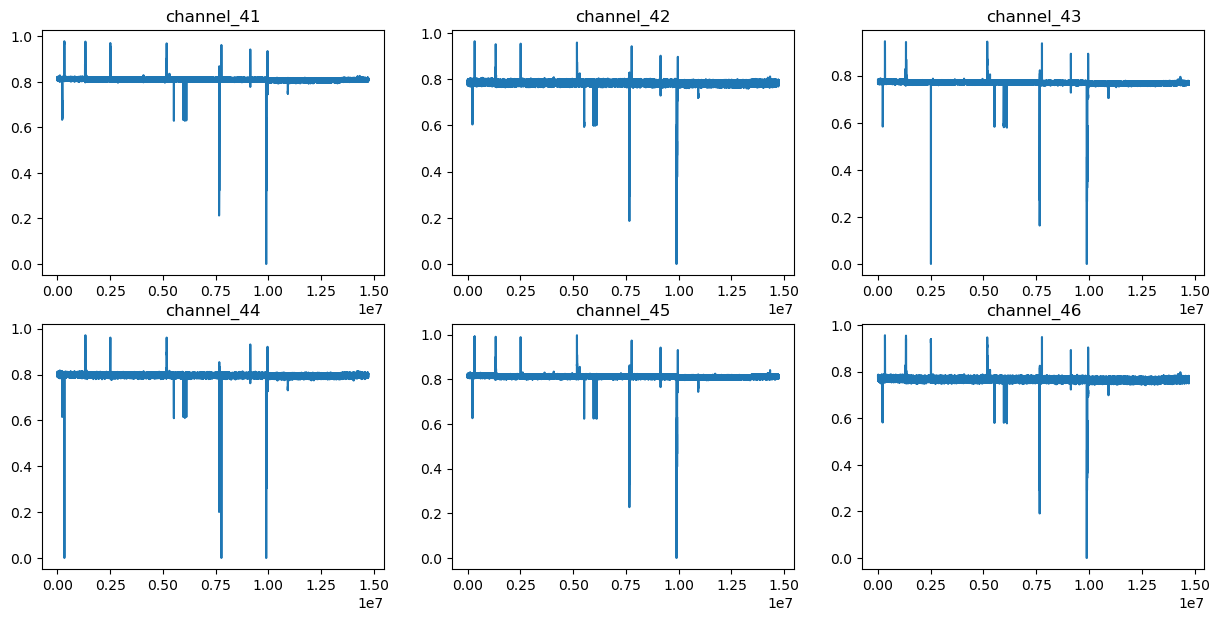

In [8]:
figure, axis = plt.subplots(2, 3)

X = df_sample['id']
Y1 = df_sample['channel_41']
Y2 = df_sample['channel_42']
Y3 = df_sample['channel_43']
Y4 = df_sample['channel_44']
Y5 = df_sample['channel_45']
Y6 = df_sample['channel_46']

figure.set_figheight(7)
figure.set_figwidth(15)

axis[0, 0].plot(X, Y1)
axis[0, 0].set_title("channel_41")

axis[0, 1].plot(X, Y2)
axis[0, 1].set_title("channel_42")

axis[0, 2].plot(X, Y3)
axis[0, 2].set_title("channel_43")

axis[1, 0].plot(X, Y4)
axis[1, 0].set_title("channel_44")

axis[1, 1].plot(X, Y5)
axis[1, 1].set_title("channel_45")

axis[1, 2].plot(X, Y6)
axis[1, 2].set_title("channel_46")

plt.show()

From the charts above, the data in the channels look very similar. Also, it's not clear whether the data points that shoot up are outliers or not (since the dataset has already been processed and treated by ESA)

The independent variables are plotted in the same chart, while the anomaly column is plotted below for visualization of the entire dataset.

### 2.2 Visualize all data

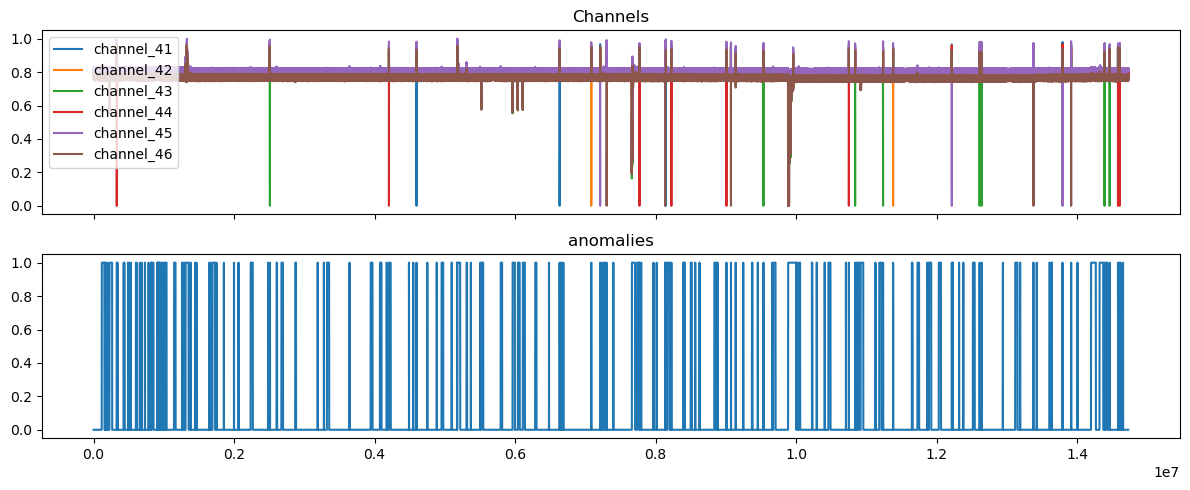

In [9]:
# Visualize all channels in different charts

df_analysis = df_train_4146

fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
for i in ['channel_41', 'channel_42', 'channel_43', 'channel_44', 'channel_45', 'channel_46']:
    ax[0].plot(df_analysis['id'], df_analysis[i], label=i)

ax[0].set_title('Channels')
ax[0].legend(loc='upper left')

ax[1].plot(df_analysis['id'], df_analysis['is_anomaly'])
ax[1].set_title('anomalies')

plt.tight_layout()
plt.show()

### 2.3. Plot section of original dataset and anomalies in parallel

Plotting original dataset while focusing on a specific location to observe the behavior of data and anomalies.
Plotting the is_anomaly variable at the same time, to look for potential relationships with the data.

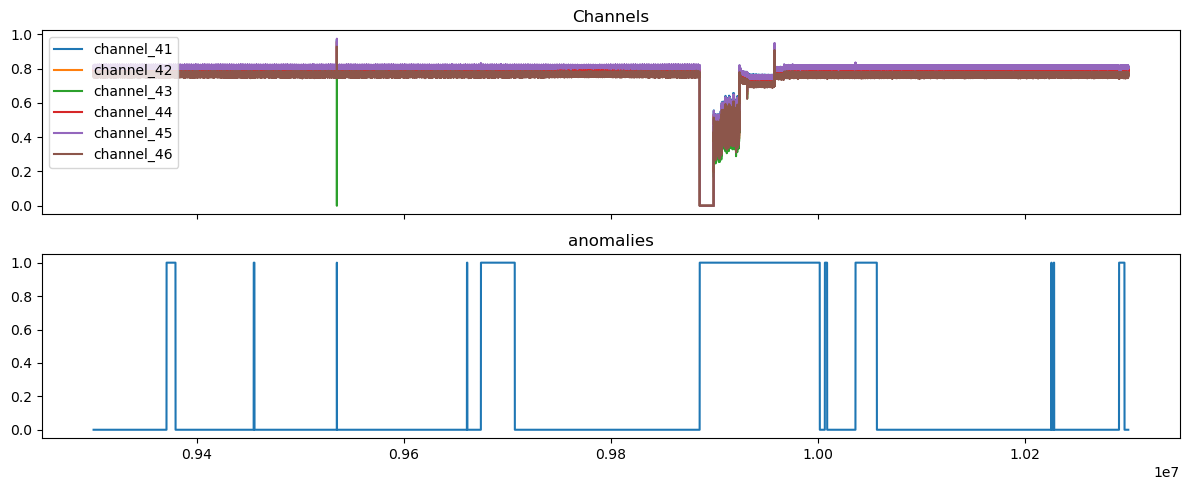

In [10]:
# From the charts above, the data in the channels look very similar. Also, it's not clear whether the data points that
# shoot up are outliers or not (since the dataset has already been processed and treated by ESA)

# Plotting original dataset while focusing on a specific location to observe the behavior of data and anomalies
# Plotting the is_anomaly variable at the same time, to look for potential relationships with the data

xmin = int(9.3*10**6)
xmax = int(10.3*10**6)
df_analysis = df_train_4146[xmin: xmax]

fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
for i in ['channel_41', 'channel_42', 'channel_43', 'channel_44', 'channel_45', 'channel_46']:
    ax[0].plot(df_analysis['id'], df_analysis[i], label=i)

ax[0].set_title('Channels')
ax[0].legend(loc='upper left')

ax[1].plot(df_analysis['id'], df_analysis['is_anomaly'])
ax[1].set_title('anomalies')

plt.tight_layout()
plt.show()

Just by looking at the data, it seems that there is a big correlation between big changes in the channel values and anomalies happening. However, it also seems that many anomalies happen without a clear change in the channel values.

By observing this behavior, it's possible to infer that the big values in the channels are not outliers, but possible explanation for the occurrence of anomalies.

Below, a similar chart as the previous one is plotted, but using the sample dataset. The objective is to check if no important information was lost during sampling, as some anomalies are very pontual. It's checked if taking a sample still keeps the properties of the original dataset.

### 2.4. Plot section of sample dataset and anomalies in parallel

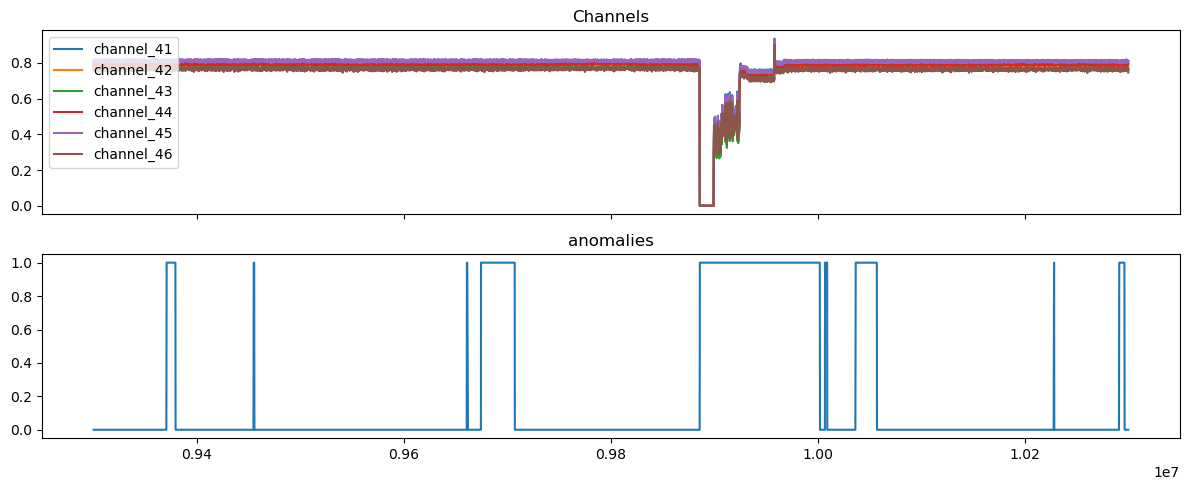

In [11]:
# Using same technique as before but with the sample dataset
# Plotting dataset while focusing on a specific location to observe the behavior of data and anomalies
# Checking if taking a sample still keeps the properties of the original dataset

xmin = int(9.3*10**6)
xmax = int(10.3*10**6)
df_analysis = df_sample[(df_sample['id'] >= xmin) & (df_sample['id'] <= xmax)]

fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
for i in ['channel_41', 'channel_42', 'channel_43', 'channel_44', 'channel_45', 'channel_46']:
    ax[0].plot(df_analysis['id'], df_analysis[i], label=i)

ax[0].set_title('Channels')
ax[0].legend(loc='upper left')

ax[1].plot(df_analysis['id'], df_analysis['is_anomaly'])
ax[1].set_title('anomalies')

plt.tight_layout()
plt.show()

It looks like the properties of the dataset were kept in the sample, so we can use it to do the initial analysis and code more efficiently. Later, the original dataset will be used to train the model and get the definitive solution.

Now, we plot a section of the original dataset where at first, it looks like there are no clear changes in the channel data while an anomaly happens, to try to find if there are any minor changes not easy to see.

### 2.5. Plot section of original dataset and anomalies, looking closely at the behavior of the data

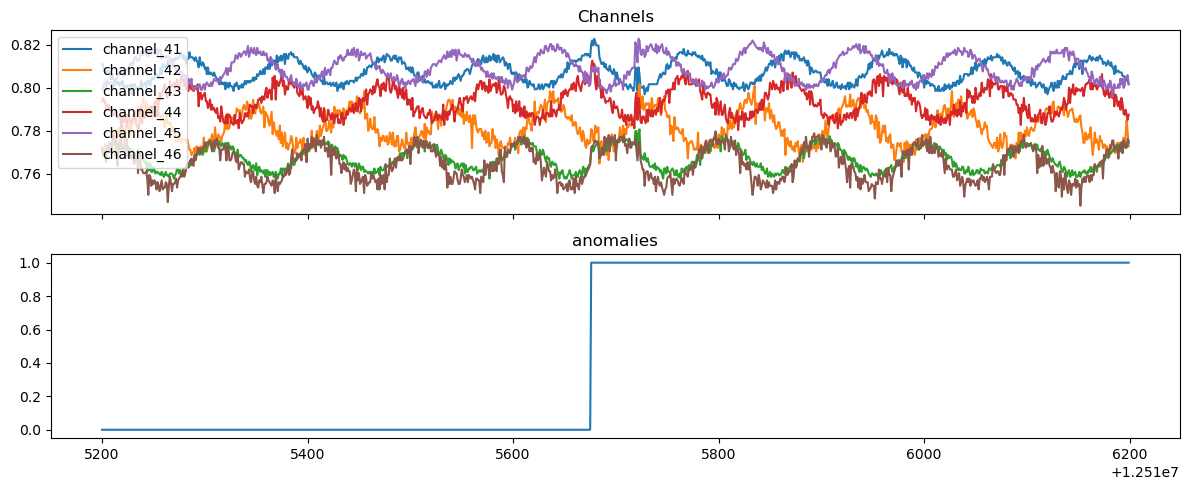

In [12]:
xmin = int(12.515200*10**6)
xmax = xmin + 1000

df_analysis = df_train_4146[xmin: xmax]

fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
for i in ['channel_41', 'channel_42', 'channel_43', 'channel_44', 'channel_45', 'channel_46']:
    ax[0].plot(df_analysis['id'], df_analysis[i], label=i)

ax[0].set_title('Channels')
ax[0].legend(loc='upper left')

ax[1].plot(df_analysis['id'], df_analysis['is_anomaly'])
ax[1].set_title('anomalies')

plt.tight_layout()
plt.show()

In this specific case, it's noticeable that a change, although small, occurs in the channel variables in a time period close to the anomaly

A similar plot will be tried in a different part of the dataset to observe, this time using the sample dataset to check for the maintenance of data properties

### 2.6. Plot section of sample dataset and anomalies, looking closely at the behavior of the data

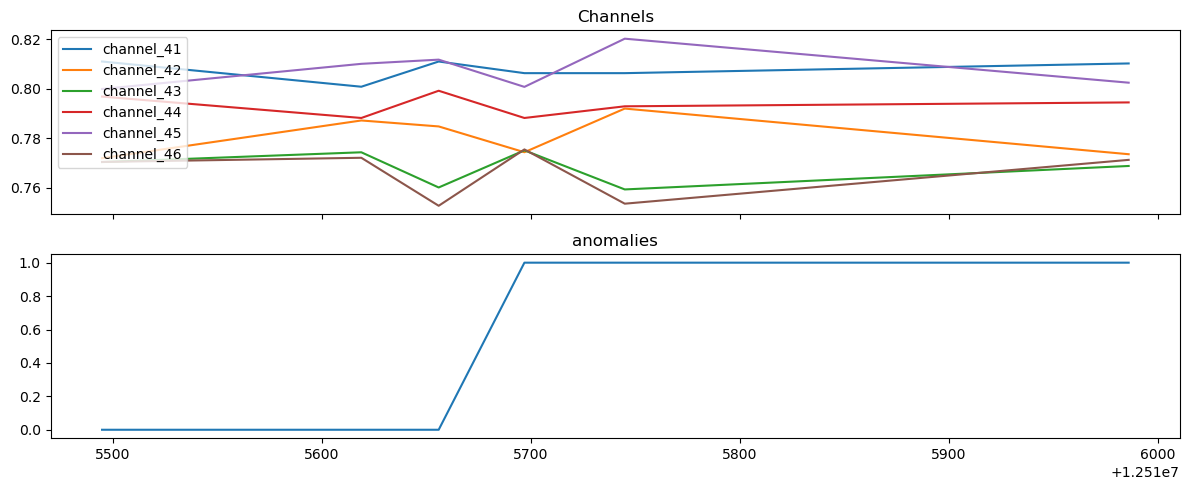

In [13]:
xmin = int(1.25152*10**7)
xmax = int(1.2516*10**7)
df_analysis = df_sample[(df_sample['id'] >= xmin) & (df_sample['id'] <= xmax)]

fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
for i in ['channel_41', 'channel_42', 'channel_43', 'channel_44', 'channel_45', 'channel_46']:
    ax[0].plot(df_analysis['id'], df_analysis[i], label=i)

ax[0].set_title('Channels')
ax[0].legend(loc='upper left')

ax[1].plot(df_analysis['id'], df_analysis['is_anomaly'])
ax[1].set_title('anomalies')

plt.tight_layout()
plt.show()

Here, it's evident that sampling the dataset has removed important features that may explain the behavior of the anomalies. A more adequate approach may be to smoothen the data, which may make it easier to analyze its behavior when anomalies happen.

## 3. Smoothen data and visualize again

### 3.1. Smoothen
At first, the moving average/rolling mean method will be used.

In [14]:
# Applying moving average/rolling mean to the original dataset

df_train_smooth = df_train_4146.copy()
for i in ['channel_41', 'channel_42', 'channel_43', 'channel_44', 'channel_45', 'channel_46']:
    df_train_smooth[i] = df_train_smooth[i].rolling(window=5, center=True).mean()
df_train_smooth

,id,channel_41,channel_42,channel_43,channel_44,channel_45,channel_46,is_anomaly
0,0,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2,0.817602,0.787468,0.770950,0.804531,0.817024,0.764789,0
3,3,0.819014,0.787468,0.770634,0.805633,0.816854,0.765464,0
4,4,0.820898,0.786504,0.770317,0.807679,0.816346,0.765633,0
...,...,...,...,...,...,...,...,...
14728316,14728316,0.806299,0.794858,0.766202,0.792881,0.821433,0.760735,0
14728317,14728317,0.806299,0.795501,0.766360,0.793510,0.821603,0.760397,0
14728318,14728318,0.806770,0.795019,0.766202,0.794140,0.821942,0.760904,0
14728319,14728319,NaN,NaN,NaN,NaN,NaN,NaN,0


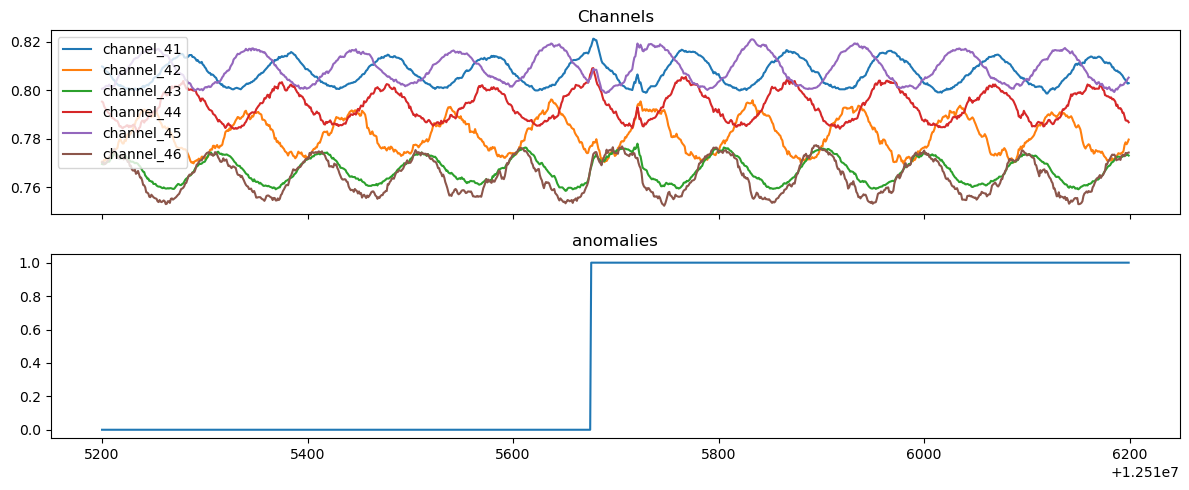

In [15]:
xmin = int(12.515200*10**6)
xmax = xmin + 1000

#xmin = int(10.227800*10**6)
#xmax = int(10.2288000*10**6)

df_analysis = df_train_smooth[xmin: xmax]

fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
for i in ['channel_41', 'channel_42', 'channel_43', 'channel_44', 'channel_45', 'channel_46']:
    ax[0].plot(df_analysis['id'], df_analysis[i], label=i)

ax[0].set_title('Channels')
ax[0].legend(loc='upper left')

ax[1].plot(df_analysis['id'], df_analysis['is_anomaly'])
ax[1].set_title('anomalies')

plt.tight_layout()
plt.show()

### 3.2. Downsampling
It will be tested whether it is possible to downsample while maintaining characteristics. If so, it will be possible to work with a more efficient code.

In [16]:
df_downsampled = df_train_smooth.iloc[::3]

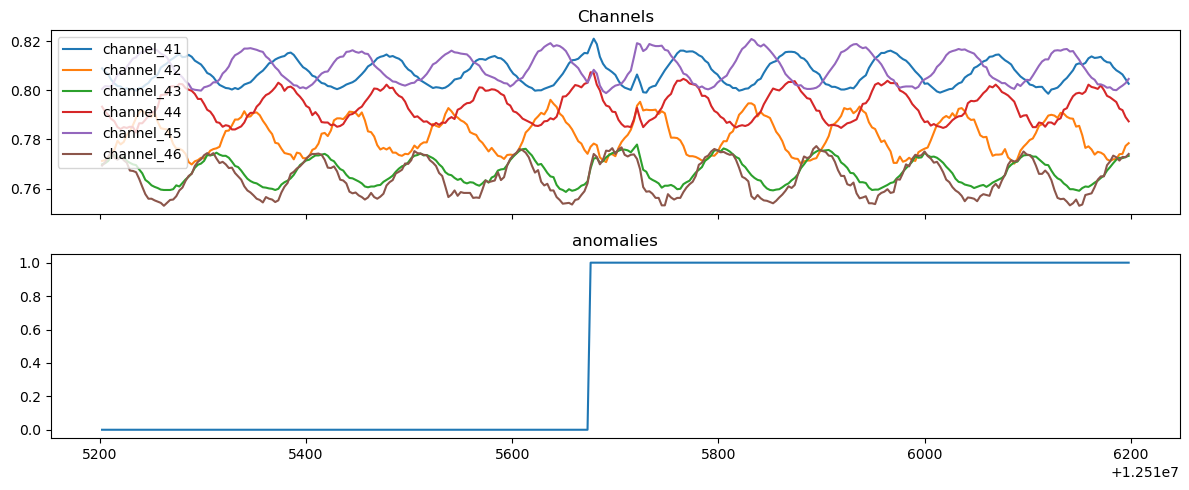

In [17]:
# Simple downsample, maintaining one line for every ndowns lines
ndowns = 3
df_downsampled = df_train_smooth.iloc[::ndowns]


xmin = int(12.515200*10**6)
xmax = xmin + 1000

df_analysis = df_downsampled[(df_downsampled['id'] >= xmin) & (df_downsampled['id'] <= xmax)]

fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
for i in ['channel_41', 'channel_42', 'channel_43', 'channel_44', 'channel_45', 'channel_46']:
    ax[0].plot(df_analysis['id'], df_analysis[i], label=i)

ax[0].set_title('Channels')
ax[0].legend(loc='upper left')

ax[1].plot(df_analysis['id'], df_analysis['is_anomaly'])
ax[1].set_title('anomalies')

plt.tight_layout()
plt.show()

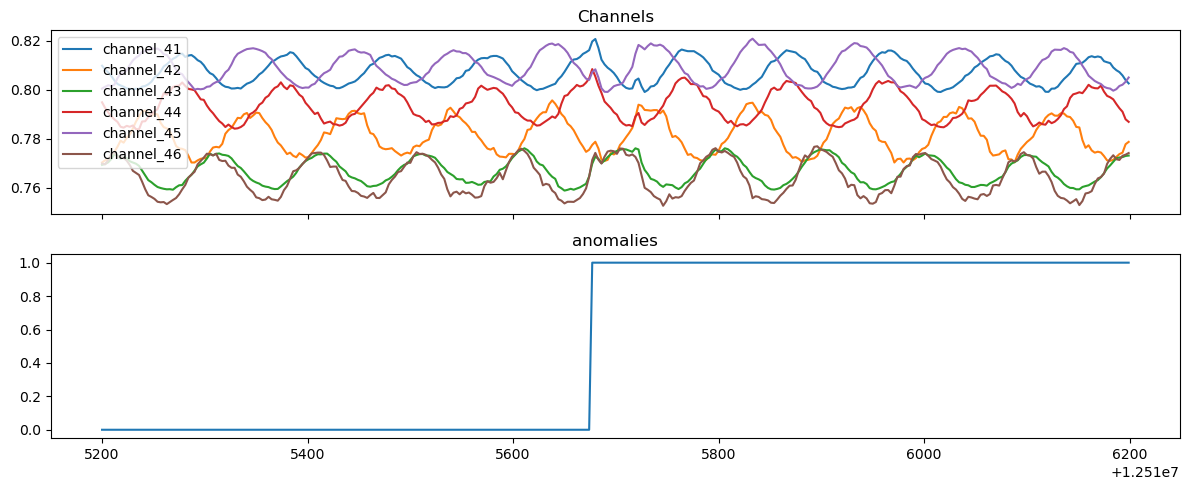

In [18]:
# Downsampling by aggregation, with ndowns-sized bins
ndowns = 3

df_downsampled = df_train_smooth.copy()
df_downsampled['group'] = (df_downsampled.index // 3)
df_downsampled = df_downsampled.groupby('group').mean()

xmin = int(12.515200*10**6)
xmax = xmin + 1000

df_analysis = df_downsampled[(df_downsampled['id'] >= xmin) & (df_downsampled['id'] <= xmax)]

fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
for i in ['channel_41', 'channel_42', 'channel_43', 'channel_44', 'channel_45', 'channel_46']:
    ax[0].plot(df_analysis['id'], df_analysis[i], label=i)

ax[0].set_title('Channels')
ax[0].legend(loc='upper left')

ax[1].plot(df_analysis['id'], df_analysis['is_anomaly'])
ax[1].set_title('anomalies')

plt.tight_layout()
plt.show()


## 4. Data Preparation
Because of the characteristics of the data, a possible good approach is to analyze the local behavior of the "waves".
For this, data will be divided into small overlapping windows.
Each window represents a small “segment” of the waveform.

Then, features will be extracted per window.
This makes the model understand patterns, not single values.

### 4.1. Define function to split dataset into windows, and FFT reconstruction function

Here we define the function "create_windows" which splits the dataset into overlapping windows. If the window contains an anomaly, the value 1 will be attributed to the window. Otherwise, the value 0 is attributed.

Next, we define a function fft_reconstruct to execute the Fourier Reconstruction of the sine waves of the original dataset. We can then apply this function for each window, and seek for variations and deviations between them to find clues about anomalies.

Finally, the function fft_features is created to extract dominant frequency, entropy and energy from the waves of each window, which may also be useful to find explanations of anomalies.

In [19]:
#Function that splits the data into overlapping windows
def create_windows(df, window_size, step_size):
    X_windows = []
    y_windows = []
    n = len(df)

    for start in range(0, n - window_size + 1, step_size):
        end = start + window_size
        window = df.iloc[start:end]

        # Save window data (only features)
        X_windows.append(window.drop(columns=['is_anomaly', 'id']).values)

        # Define window label: 1 if anomaly appears anywhere in the window
        y_windows.append(1 if window['is_anomaly'].any() else 0)

    return np.array(X_windows), np.array(y_windows)

In [20]:
# FFT Reconstruct

def fft_reconstruct(x, n_components=1, include_dc=True):
    X = np.fft.fft(x)
    mag = np.abs(X)
    
    # Initialize filtered spectrum
    X_filtered = np.zeros_like(X)
    
    # Handle DC component
    if include_dc:
        X_filtered[0] = X[0]
    
    # For real signals, only consider positive frequencies (up to Nyquist)
    n = len(x)
    positive_freqs = mag[1:n//2+1]
    
    # Find indices of top n_components (excluding DC)
    top_indices = np.argpartition(positive_freqs, -n_components)[-n_components:]
    top_indices = top_indices + 1  # Offset by 1 since we excluded DC
    
    # Keep dominant components and their conjugates
    for idx in top_indices:
        X_filtered[idx] = X[idx]
        X_filtered[-idx] = X[-idx]  # Conjugate for real signal
    
    # Reconstruct signal
    x_hat = np.fft.ifft(X_filtered).real
    residual = x - x_hat
    
    return x_hat, residual

In [21]:
def fft_features(signal, sampling_rate=1.0):
    signal = signal - np.mean(signal)
    
    n = len(signal)
    freqs = np.abs(fft(signal))
    freqs = freqs[:n//2]
    power = freqs ** 2
    
    # Get frequency bins
    freq_bins = np.fft.fftfreq(n, d=1/sampling_rate)[:n//2]
    
    # Find dominant frequency (skip DC)
    dom_freq_idx = np.argmax(power[1:]) + 1
    dom_freq_hz = freq_bins[dom_freq_idx]
    
    energy = np.sum(power)
    p_norm = power / np.sum(power)
    spec_entropy = entropy(p_norm[p_norm > 0])  # avoid log(0)
    
    return dom_freq_hz, energy, spec_entropy


def fft_features_normalized(signal):
    signal = signal - np.mean(signal)
    
    n = len(signal)
    freqs = np.abs(fft(signal))
    freqs = freqs[:n//2]
    power = freqs ** 2
    
    # Skip DC component
    dom_freq_idx = np.argmax(power[1:]) + 1
    
    # Express as cycles per window (or cycles per 400 samples)
    dom_freq_normalized = dom_freq_idx / n
    
    energy = np.sum(power)
    p_norm = power / (np.sum(power) + 1e-10)
    spec_entropy = entropy(p_norm[p_norm > 0])
    
    return {
        'dom_freq_bin': dom_freq_idx,
        'dom_freq_cycles_per_window': dom_freq_normalized,
        'energy': energy,
        'spec_entropy': spec_entropy
    }


### 4.2. Define window size and apply FFT - downsampled and smoothened dataset

First, we approach the problem using the downsampled and smoothened dataset, as it seems to have maintained the most important features of the original one, while enabling us to save processinig power.

Ideally, the window size should be 1-2 × the average period length of the wave.

In [22]:
df_downsampled.head()

,id,channel_41,channel_42,channel_43,channel_44,channel_45,channel_46,is_anomaly
group,,,,,,,,
0,1.0,0.817602,0.787468,0.770950,0.804531,0.817024,0.764789,0.0
1,4.0,0.820218,0.786504,0.770528,0.806787,0.816346,0.765802,0.0
2,7.0,0.821055,0.782221,0.770686,0.807312,0.813972,0.767041,0.0
3,10.0,0.821003,0.780239,0.771003,0.808834,0.812276,0.767829,0.0
4,13.0,0.820322,0.782756,0.772216,0.809202,0.811541,0.769461,0.0


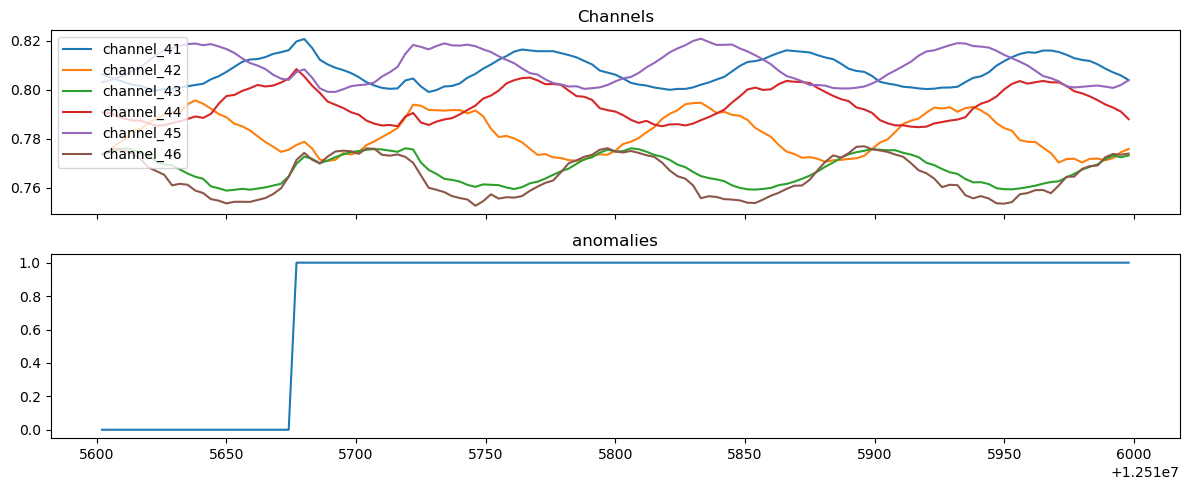

In [23]:
# Visualize possible window size
xmin = int(12.515600*10**6)
xmax = xmin + 400

df_analysis = df_downsampled[(df_downsampled['id'] >= xmin) & (df_downsampled['id'] <= xmax)]

fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
for i in ['channel_41', 'channel_42', 'channel_43', 'channel_44', 'channel_45', 'channel_46']:
    ax[0].plot(df_analysis['id'], df_analysis[i], label=i)

ax[0].set_title('Channels')
ax[0].legend(loc='upper left')

ax[1].plot(df_analysis['id'], df_analysis['is_anomaly'])
ax[1].set_title('anomalies')

plt.tight_layout()
plt.show()

In [24]:
df_analysis.shape

(133, 8)

Above, we can see that one wave period is equivalent to around 100 samples. Thus, what we want are windows of 400 samples to split the dataset, with overlap of 50% (200 samples).

However, in the downsampled dataset, the 400 samples from the original one are equivalent to 133 samples.
So we define the window size as 150 samples (rounding up), with 50% (75 samples) overlap

In [25]:
window_size = 150      # number of samples per window
step_size = 75        # how much to move the window each time (50% overlap)
n_channels = 6

X_down, y_down = create_windows(df_downsampled, window_size, step_size)
print(X_down.shape)
print(y_down.shape)

(65458, 150, 6)
(65458,)


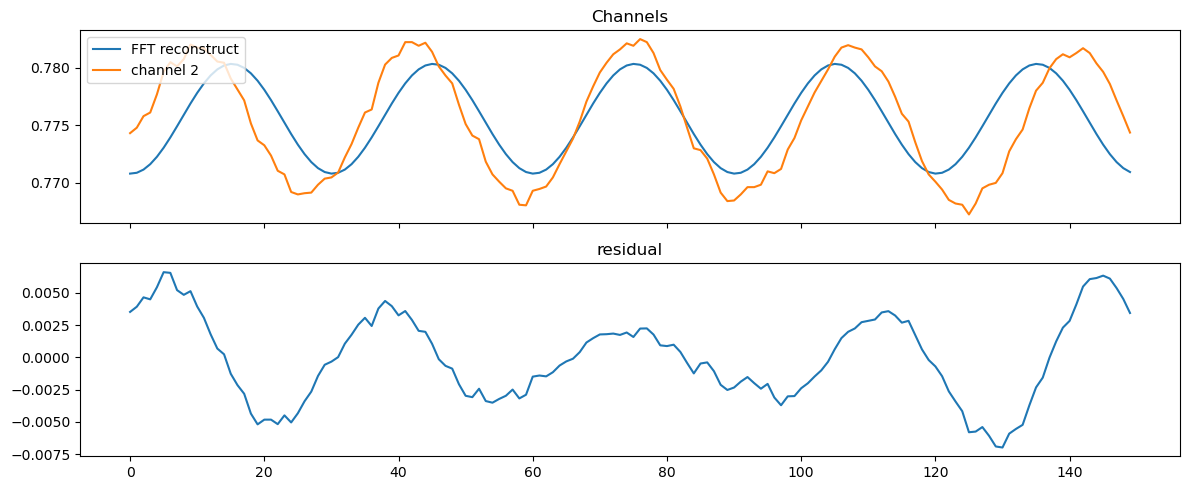

In [26]:
channel_selected = 2

x_hat_test, residual_test = fft_reconstruct(X_down[42][:,channel_selected], 1)

fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True)

ax[0].plot(x_hat_test, label='FFT reconstruct')
ax[0].plot(X_down[42][:,channel_selected], label=f"channel {channel_selected}")

ax[0].set_title('Channels')
ax[0].legend(loc='upper left')

ax[1].plot(residual_test)
ax[1].set_title('residual')

plt.tight_layout()
plt.show()

By applying the FFT reconstruction in the smoothened dataset, it is evident that the algorithm is not able to interpolate the sine wave in an ideal way, as the sine wave has an increasing offset as we approach the extremities of the window.

For that reason, we try to apply the same algorithm in the Original Dataset and evaluate the results.

### 4.3. Define window size and apply FFT - Original Dataset

In [27]:
window_size = 400      # number of samples per window
step_size = 200        # how much to move the window each time (50% overlap)
n_channels = 6

X, y = create_windows(df_train_4146, window_size, step_size)
print(X.shape)
print(y.shape)

(73640, 400, 6)
(73640,)


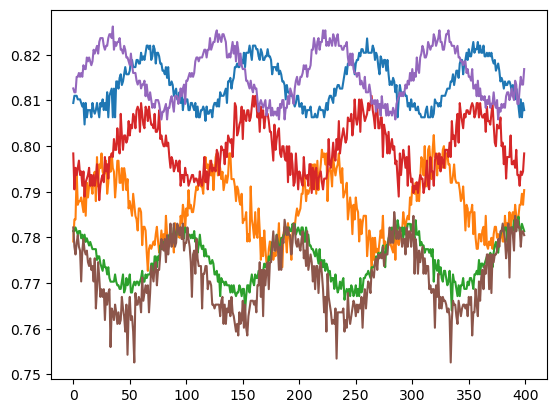

In [28]:
plt.plot(X[42])

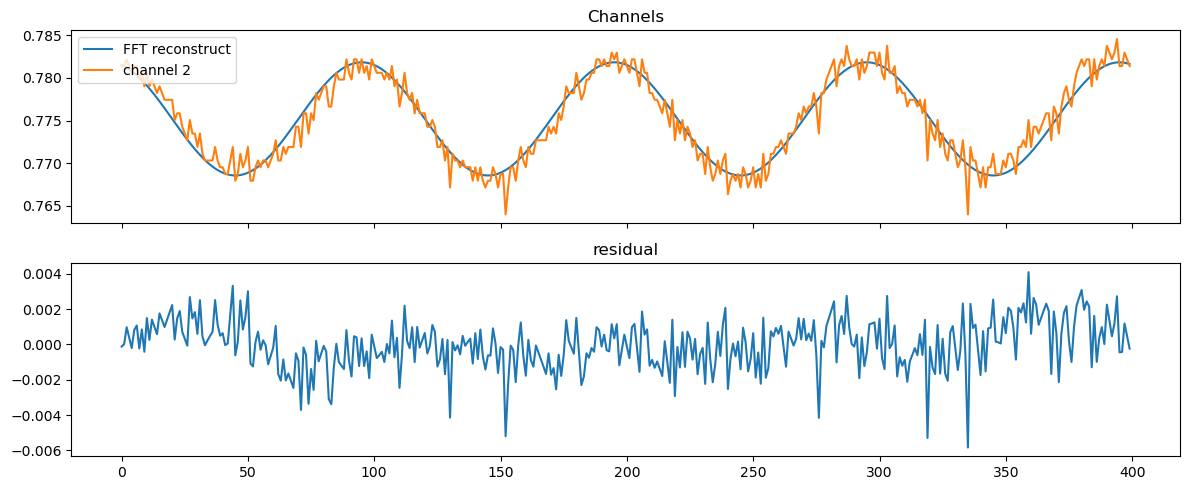

In [29]:
channel_selected = 2

x_hat_test, residual_test = fft_reconstruct(X[42][:,channel_selected], 1)

fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True)

ax[0].plot(x_hat_test, label='FFT reconstruct')
ax[0].plot(X[42][:,channel_selected], label=f"channel {channel_selected}")

ax[0].set_title('Channels')
ax[0].legend(loc='upper left')

ax[1].plot(residual_test)
ax[1].set_title('residual')

plt.tight_layout()
plt.show()

In [30]:
channel_selected = 2

dom_freq_test, energy_test, spec_entropy_test = fft_features(X[42][:,channel_selected])
print(dom_freq_test, energy_test, spec_entropy_test)

0.01 1.9222547 0.65083116


In [31]:
channel_selected = 2

result = fft_features_normalized(X[42][:,channel_selected])
print(result)

{'dom_freq_bin': 4, 'dom_freq_cycles_per_window': 0.01, 'energy': 1.9222547, 'spec_entropy': 0.65083116}


In [32]:
result = fft_features_normalized(X[42][:,channel_selected])
dom_freq_bin = result['dom_freq_bin']
energy = result['energy']
spec_entropy = result['spec_entropy']
cycles_per_window = result['dom_freq_cycles_per_window']
print(result)

{'dom_freq_bin': 4, 'dom_freq_cycles_per_window': 0.01, 'energy': 1.9222547, 'spec_entropy': 0.65083116}


Here, we can see that the FFT algorithm interpolates the signal in a much more optimal way, compared to the downsampled dataset.

Moreover, the processing power required was not excessive, as it only took 33 seconds to split the 14M+ rows dataset into the overlapping windows.

### 4.4. Compute statistical features (per channel, per window)

We define the function "extract_features_from_window_v1", that will extract the features from each window by applying the FFT function and any other that we may desire.

In [33]:
def spectral_entropy(ps):
    ps = np.maximum(ps, 1e-12)
    ps_norm = ps / ps.sum()
    return -np.sum(ps_norm * np.log(ps_norm))

In [34]:
# Extract features from window
def extract_features_from_window_v1(window):

    num_channels = window.shape[1]
    features = {}

    for i in range(num_channels):
        data = window[:, i]

        # Basic stats
        x_hat, r = fft_reconstruct(data)

        features[f"ch{i+1}_mse"] = np.mean(r**2)
        # features[f"ch{i+1}_rmse"] = np.sqrt(features['mse'])
        features[f"ch{i+1}_mse_norm"] = np.mean(r**2) / (np.mean(data**2) + 1e-12)
        features[f"ch{i+1}_max_abs_res"] = np.max(np.abs(r))
        features[f"ch{i+1}_std_res"] = np.std(r)
        # features[f"ch{i+1}_skew_res"] = skew(r)
        # features[f"ch{i+1}_kurtosis_res"] = kurtosis(r)
        # features[f"ch{i+1}_res_energy_ratio"] = np.sum(r**2) / (np.sum(data**2) + 1e-12)

        # Key Frequency Features
        result = fft_features_normalized(data)

        features[f"ch{i+1}_dom_freq_bin"] = result['dom_freq_bin']
        features[f"ch{i+1}_spec_entropy"] = result['spec_entropy']
        features[f"ch{i+1}_cycles_per_window"] = result['dom_freq_cycles_per_window']
        # features[f"ch{i+1}_energy"] = result['energy']


        # Slope/derivative feature
        derivative = np.diff(data)
        features[f"ch{i+1}_max_abs_derivative"] = np.max(np.abs(derivative))
        features[f"ch{i+1}_std_derivative"] = np.std(derivative)
        
        second_derivative = np.diff(derivative)
        features[f"ch{i+1}_max_abs_2nd_deriv"] = np.max(np.abs(second_derivative))
        
        # Energy ratio
        fft_vals = rfft(data)
        power_spectrum = np.abs(fft_vals)**2
        total_energy = np.sum(power_spectrum)
        
        k_fixed = min(5, len(fft_vals))
        top_5_energy = np.sum(np.sort(power_spectrum)[-k_fixed:])
        features[f"ch{i+1}_energy_ratio_top5"] = top_5_energy / (total_energy + 1e-12)
        
    return features

Then we apply the function in the windows dataset X, extracting the features from the windows:

In [35]:
feature_rows = []
for window in X:
    feats = extract_features_from_window_v1(window)
    feature_rows.append(feats)

X_features = pd.DataFrame(feature_rows)
X_features['is_anomaly'] = y

In [37]:
X_features.shape

(73640, 67)

In [38]:
X_features.head()

,ch1_mse,ch1_mse_norm,ch1_max_abs_res,ch1_std_res,ch1_dom_freq_bin,ch1_spec_entropy,ch1_cycles_per_window,ch1_max_abs_derivative,ch1_std_derivative,ch1_max_abs_2nd_deriv,...,ch6_max_abs_res,ch6_std_res,ch6_dom_freq_bin,ch6_spec_entropy,ch6_cycles_per_window,ch6_max_abs_derivative,ch6_std_derivative,ch6_max_abs_2nd_deriv,ch6_energy_ratio_top5,is_anomaly
0,0.000002,0.000003,0.007399,0.001382,4,0.686204,0.01,0.008634,0.001822,0.010205,...,0.012756,0.002785,4,1.297575,0.01,0.015200,0.003767,0.026178,0.999994,0
1,0.000002,0.000003,0.004994,0.001446,4,0.686016,0.01,0.005495,0.001700,0.008634,...,0.014786,0.002952,4,1.416813,0.01,0.015200,0.003821,0.026178,0.999994,0
2,0.000002,0.000002,0.004702,0.001251,4,0.536496,0.01,0.004710,0.001468,0.009420,...,0.011481,0.002992,4,1.376423,0.01,0.014356,0.003946,0.023647,0.999994,0
3,0.000002,0.000003,0.005572,0.001293,4,0.567022,0.01,0.004710,0.001452,0.009420,...,0.010014,0.003014,4,1.434323,0.01,0.015202,0.003987,0.024491,0.999993,0
4,0.000002,0.000003,0.005739,0.001447,4,0.644879,0.01,0.006279,0.001585,0.012558,...,0.010327,0.002866,4,1.248243,0.01,0.015202,0.003896,0.025336,0.999994,0


In [39]:
X_features.to_csv('X_features.csv', index=False)

## 5. Initial Data Exploration

In [40]:
X_features = pd.read_csv('X_features.csv')
X_features.head()

,ch1_mse,ch1_mse_norm,ch1_max_abs_res,ch1_std_res,ch1_dom_freq_bin,ch1_spec_entropy,ch1_cycles_per_window,ch1_max_abs_derivative,ch1_std_derivative,ch1_max_abs_2nd_deriv,...,ch6_max_abs_res,ch6_std_res,ch6_dom_freq_bin,ch6_spec_entropy,ch6_cycles_per_window,ch6_max_abs_derivative,ch6_std_derivative,ch6_max_abs_2nd_deriv,ch6_energy_ratio_top5,is_anomaly
0,0.000002,0.000003,0.007399,0.001382,4,0.686204,0.01,0.008634,0.001822,0.010205,...,0.012756,0.002785,4,1.297575,0.01,0.015200,0.003767,0.026178,0.999994,0
1,0.000002,0.000003,0.004994,0.001446,4,0.686016,0.01,0.005495,0.001700,0.008634,...,0.014786,0.002952,4,1.416813,0.01,0.015200,0.003821,0.026178,0.999994,0
2,0.000002,0.000002,0.004702,0.001251,4,0.536496,0.01,0.004710,0.001468,0.009420,...,0.011481,0.002992,4,1.376423,0.01,0.014356,0.003946,0.023647,0.999994,0
3,0.000002,0.000003,0.005572,0.001293,4,0.567022,0.01,0.004710,0.001452,0.009420,...,0.010014,0.003014,4,1.434323,0.01,0.015202,0.003987,0.024491,0.999993,0
4,0.000002,0.000003,0.005739,0.001447,4,0.644879,0.01,0.006279,0.001585,0.012558,...,0.010327,0.002866,4,1.248243,0.01,0.015202,0.003896,0.025336,0.999994,0


In [60]:
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings

### 5.1. Data preparation and visualization of statistics

In [44]:
def prepare_data(X_features):
    """
    Separate the target variable from features.
    
    Parameters:
    -----------
    X_features : pd.DataFrame
        Complete dataset with 'is_anomaly' as last column
        
    Returns:
    --------
    X : pd.DataFrame
        Feature matrix (66 columns)
    y : pd.Series
        Target variable (is_anomaly)
    """
    print("=" * 80)
    print("DATA PREPARATION")
    print("=" * 80)
    
    # Separate features and target
    y = X_features['is_anomaly']
    X = X_features.drop('is_anomaly', axis=1)
    
    print(f"✅ Separated features and target")
    print(f"   Features shape: {X.shape}")
    print(f"   Target shape: {y.shape}")
    print(f"   Total columns: {X.shape[1]} features + 1 target = {X_features.shape[1]}")
    
    # Verify we have 66 features (11 per channel × 6 channels)
    assert X.shape[1] == 66, f"Expected 66 features but got {X.shape[1]}"
    print(f"   ✓ Confirmed: 66 features (11 features × 6 channels)")
    
    return X, y

In [55]:
X, y = prepare_data(X_features)

DATA PREPARATION
✅ Separated features and target
   Features shape: (73640, 66)
   Target shape: (73640,)
   Total columns: 66 features + 1 target = 67
   ✓ Confirmed: 66 features (11 features × 6 channels)


In [56]:
def explore_features(X, y):
    """
    Initial exploration of the feature dataset.
    """

    print("\n" + "=" * 80)
    print("FEATURE DATASET OVERVIEW")
    print("=" * 80)
    print(f"Shape: {X.shape}")
    print(f"Number of features: {X.shape[1]}")
    print(f"Number of samples: {X.shape[0]}")
    print(f"\nClass distribution:")
    print(y.value_counts())
    print(f"Anomaly rate: {y.mean():.4f} ({y.sum()} anomalies out of {len(y)} samples)")
    
    # Analyze features by channel
    print("\n" + "=" * 80)
    print("FEATURES BY CHANNEL (11 features per channel)")
    print("=" * 80)
    
    feature_names = X.columns.tolist()
    channels = {}
    for feat in feature_names:
        channel = feat.split('_')[0]  # e.g., 'ch1', 'ch2', etc.
        if channel not in channels:
            channels[channel] = []
        channels[channel].append(feat)
    
    for ch in sorted(channels.keys()):
        print(f"\n{ch.upper()} ({len(channels[ch])} features):")
        for i, feat in enumerate(channels[ch], 1):
            feat_name = '_'.join(feat.split('_')[1:])
            print(f"  {i:2d}. {feat_name}")
    
    print("\n" + "=" * 80)
    print("FEATURE STATISTICS")
    print("=" * 80)
    print(X.describe().T)
    
    # Check for constant or near-constant features
    std_values = X.std()
    low_variance = std_values[std_values < 1e-6]
    if len(low_variance) > 0:
        print(f"\n⚠️  Features with very low variance (< 1e-6): {len(low_variance)}")
        print(low_variance)
    
    return X.describe()

In [57]:
explore_features(X, y)


FEATURE DATASET OVERVIEW
Shape: (73640, 66)
Number of features: 66
Number of samples: 73640

Class distribution:
is_anomaly
0    65554
1     8086
Name: count, dtype: int64
Anomaly rate: 0.1098 (8086 anomalies out of 73640 samples)

FEATURES BY CHANNEL (11 features per channel)

CH1 (11 features):
   1. mse
   2. mse_norm
   3. max_abs_res
   4. std_res
   5. dom_freq_bin
   6. spec_entropy
   7. cycles_per_window
   8. max_abs_derivative
   9. std_derivative
  10. max_abs_2nd_deriv
  11. energy_ratio_top5

CH2 (11 features):
   1. mse
   2. mse_norm
   3. max_abs_res
   4. std_res
   5. dom_freq_bin
   6. spec_entropy
   7. cycles_per_window
   8. max_abs_derivative
   9. std_derivative
  10. max_abs_2nd_deriv
  11. energy_ratio_top5

CH3 (11 features):
   1. mse
   2. mse_norm
   3. max_abs_res
   4. std_res
   5. dom_freq_bin
   6. spec_entropy
   7. cycles_per_window
   8. max_abs_derivative
   9. std_derivative
  10. max_abs_2nd_deriv
  11. energy_ratio_top5

CH4 (11 features):
  

,ch1_mse,ch1_mse_norm,ch1_max_abs_res,ch1_std_res,ch1_dom_freq_bin,ch1_spec_entropy,ch1_cycles_per_window,ch1_max_abs_derivative,ch1_std_derivative,ch1_max_abs_2nd_deriv,...,ch6_mse_norm,ch6_max_abs_res,ch6_std_res,ch6_dom_freq_bin,ch6_spec_entropy,ch6_cycles_per_window,ch6_max_abs_derivative,ch6_std_derivative,ch6_max_abs_2nd_deriv,ch6_energy_ratio_top5
count,73640.000000,73640.000000,73640.000000,73640.000000,73640.000000,73640.000000,73640.000000,73640.000000,73640.000000,73640.000000,...,73640.000000,73640.000000,73640.000000,73640.000000,73640.000000,73640.000000,73640.000000,73640.000000,73640.000000,73640.000000
mean,0.000010,0.000037,0.006533,0.001721,3.993658,0.847640,0.009984,0.007227,0.001848,0.012523,...,0.000051,0.012606,0.003256,3.993672,1.564291,0.009984,0.015248,0.004112,0.026528,0.999088
std,0.000279,0.001823,0.010694,0.002681,0.526283,0.415420,0.001316,0.012152,0.001068,0.018825,...,0.001834,0.011507,0.002510,0.321364,0.445252,0.000803,0.012718,0.001003,0.020969,0.029926
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.002500,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.002500,0.000000,0.000000,0.000000,0.000000
25%,0.000002,0.000003,0.004971,0.001389,4.000000,0.614771,0.010000,0.005494,0.001666,0.009420,...,0.000015,0.010853,0.002921,4.000000,1.292831,0.010000,0.013511,0.003859,0.022802,0.999993
50%,0.000002,0.000003,0.005676,0.001477,4.000000,0.703244,0.010000,0.006279,0.001736,0.010989,...,0.000016,0.011765,0.003052,4.000000,1.430926,0.010000,0.014356,0.004020,0.025333,0.999993
75%,0.000003,0.000004,0.006508,0.001634,4.000000,0.905323,0.010000,0.007064,0.001810,0.012558,...,0.000018,0.012830,0.003218,4.000000,1.675621,0.010000,0.015202,0.004194,0.027025,0.999994
max,0.051228,0.424839,0.807961,0.226337,132.000000,5.291755,0.330000,0.819642,0.057944,1.636145,...,0.425911,0.766502,0.214019,65.000000,5.287859,0.162500,0.772051,0.054755,1.542412,1.000000


### 5.2. Analyze feature correlation

In [58]:
def analyze_feature_correlations(X, threshold=0.95):
    """
    Find highly correlated features within and across channels.
    """
    print("\n" + "=" * 80)
    print("CORRELATION ANALYSIS")
    print("=" * 80)
    
    # Compute correlation matrix
    corr_matrix = X.corr().abs()
    
    # Find highly correlated pairs
    upper_triangle = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    
    highly_correlated = []
    for column in upper_triangle.columns:
        correlated_features = upper_triangle[column][upper_triangle[column] > threshold]
        for feat in correlated_features.index:
            highly_correlated.append((column, feat, upper_triangle.loc[feat, column]))
    
    if highly_correlated:
        print(f"\n🔍 Found {len(highly_correlated)} highly correlated pairs (>{threshold}):")
        corr_df = pd.DataFrame(highly_correlated, columns=['Feature 1', 'Feature 2', 'Correlation'])
        
        # Categorize correlations
        within_channel = []
        across_channel = []
        for _, row in corr_df.iterrows():
            ch1 = row['Feature 1'].split('_')[0]
            ch2 = row['Feature 2'].split('_')[0]
            if ch1 == ch2:
                within_channel.append(row)
            else:
                across_channel.append(row)
        
        print(f"\n  Within same channel: {len(within_channel)} pairs")
        print(f"  Across different channels: {len(across_channel)} pairs")
        
        if within_channel:
            print("\n  📊 Within-channel correlations (top 10):")
            print(pd.DataFrame(within_channel).head(10))
        
        if across_channel:
            print("\n  📊 Cross-channel correlations (top 10):")
            print(pd.DataFrame(across_channel).head(10))
        
        # Smart feature selection: keep first occurrence, drop duplicates
        features_to_drop = set()
        for feat1, feat2, corr in highly_correlated:
            # Keep the feature from the lower-numbered channel
            ch1_num = int(feat1.split('_')[0].replace('ch', ''))
            ch2_num = int(feat2.split('_')[0].replace('ch', ''))
            if ch1_num < ch2_num:
                features_to_drop.add(feat2)
            else:
                features_to_drop.add(feat1)
        
        print(f"\n💡 Suggested features to drop: {len(features_to_drop)}")
        if len(features_to_drop) <= 20:
            for feat in sorted(features_to_drop):
                print(f"  - {feat}")
        else:
            print(f"  First 20: {sorted(list(features_to_drop))[:20]}")
    else:
        print(f"✅ No highly correlated features found (threshold={threshold})")
        features_to_drop = set()
    
    return features_to_drop, corr_matrix

In [63]:
corr_threshold = 0.95

corr_features_to_drop, corr_matrix = analyze_feature_correlations(X, threshold=corr_threshold)


CORRELATION ANALYSIS

🔍 Found 43 highly correlated pairs (>0.95):

  Within same channel: 17 pairs
  Across different channels: 26 pairs

  📊 Within-channel correlations (top 10):
                 Feature 1         Feature 2  Correlation
0    ch1_cycles_per_window  ch1_dom_freq_bin     1.000000
1   ch1_max_abs_derivative   ch1_max_abs_res     0.972517
2    ch1_max_abs_2nd_deriv   ch1_max_abs_res     0.960527
6    ch2_cycles_per_window  ch2_dom_freq_bin     1.000000
7   ch2_max_abs_derivative   ch2_max_abs_res     0.957539
10   ch3_cycles_per_window  ch3_dom_freq_bin     1.000000
11  ch3_max_abs_derivative   ch3_max_abs_res     0.974113
12   ch3_max_abs_2nd_deriv   ch3_max_abs_res     0.964247
13   ch4_cycles_per_window  ch4_dom_freq_bin     1.000000
14  ch4_max_abs_derivative   ch4_max_abs_res     0.968026

  📊 Cross-channel correlations (top 10):
                Feature 1              Feature 2  Correlation
3                 ch2_mse                ch1_mse     0.997176
4            ch

In [64]:
X_reduced = X.drop(columns=list(corr_features_to_drop))
print(f"\n✂️  Removed {len(corr_features_to_drop)} correlated features")
print(f"   Remaining features: {X_reduced.shape[1]}/66")


✂️  Removed 31 correlated features
   Remaining features: 35/66


### 5.3. Feature Importance Analysis

In [65]:
def calculate_feature_importance(X, y, sample_size=1000000):
    """
    Calculate feature importance using multiple methods.
    """
    print("\n" + "=" * 80)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("=" * 80)
    
    # Sample for faster computation if dataset is large
    if len(X) > sample_size:
        print(f"📊 Sampling {sample_size} rows for analysis...")
        indices = np.random.choice(len(X), sample_size, replace=False)
        X_sample = X.iloc[indices]
        y_sample = y.iloc[indices]
    else:
        X_sample = X
        y_sample = y
    
    # Method 1: Random Forest Feature Importance
    print("\n1️⃣  Random Forest Feature Importance...")
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'  # Important for imbalanced data
    )
    rf.fit(X_sample, y_sample)
    
    rf_importance = pd.DataFrame({
        'feature': X.columns,
        'rf_importance': rf.feature_importances_
    }).sort_values('rf_importance', ascending=False)
    
    print("\nTop 20 features by Random Forest:")
    print(rf_importance.head(20))
    
    # Method 2: Mutual Information
    print("\n2️⃣  Mutual Information...")
    mi_scores = mutual_info_classif(X_sample, y_sample, random_state=42)
    
    mi_importance = pd.DataFrame({
        'feature': X.columns,
        'mi_score': mi_scores
    }).sort_values('mi_score', ascending=False)
    
    print("\nTop 20 features by Mutual Information:")
    print(mi_importance.head(20))
    
    # Combine both methods
    importance_combined = rf_importance.merge(mi_importance, on='feature')
    importance_combined['combined_score'] = (
        importance_combined['rf_importance'].rank() + 
        importance_combined['mi_score'].rank()
    )
    importance_combined = importance_combined.sort_values('combined_score', ascending=False)
    
    # Add channel information
    importance_combined['channel'] = importance_combined['feature'].apply(
        lambda x: x.split('_')[0]
    )
    importance_combined['feature_type'] = importance_combined['feature'].apply(
        lambda x: '_'.join(x.split('_')[1:])
    )
    
    return importance_combined, rf

In [67]:
importance_df, rf_model = calculate_feature_importance(X_reduced, y)


FEATURE IMPORTANCE ANALYSIS

1️⃣  Random Forest Feature Importance...

Top 20 features by Random Forest:
                  feature  rf_importance
1            ch1_mse_norm       0.074261
25       ch4_spec_entropy       0.072228
0                 ch1_mse       0.065840
19  ch3_energy_ratio_top5       0.061944
27  ch4_energy_ratio_top5       0.055411
33       ch6_spec_entropy       0.052510
10       ch2_spec_entropy       0.051991
16            ch3_std_res       0.047997
3             ch1_std_res       0.046548
21           ch4_mse_norm       0.041775
5        ch1_spec_entropy       0.041748
14           ch3_mse_norm       0.037213
13                ch3_mse       0.033489
23            ch4_std_res       0.032248
7   ch1_energy_ratio_top5       0.031199
2         ch1_max_abs_res       0.028584
18     ch3_std_derivative       0.026219
15        ch3_max_abs_res       0.021359
20                ch4_mse       0.021207
30     ch5_std_derivative       0.019400

2️⃣  Mutual Information...

Top 

### 5.4. Select Top Features

In [68]:
# ============================================================================
# STEP 4: SELECT TOP FEATURES
# ============================================================================

def select_top_features(importance_df, n_features=30, min_per_channel=3):
    """
    Select top n features ensuring representation from all channels.
    
    Parameters:
    -----------
    importance_df : pd.DataFrame
        Feature importance dataframe
    n_features : int
        Total number of features to select
    min_per_channel : int
        Minimum features per channel to ensure diversity
    """
    print("\n" + "=" * 80)
    print(f"SELECTING TOP {n_features} FEATURES")
    print("=" * 80)
    
    # Strategy 1: Pure top-N selection
    top_features_pure = importance_df.head(n_features)['feature'].tolist()
    
    # Strategy 2: Balanced selection across channels
    top_features_balanced = []
    channels = ['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6']
    
    # First, ensure minimum representation from each channel
    for channel in channels:
        channel_features = importance_df[importance_df['channel'] == channel].head(min_per_channel)
        top_features_balanced.extend(channel_features['feature'].tolist())
    
    # Then, add remaining top features
    remaining = n_features - len(top_features_balanced)
    if remaining > 0:
        already_selected = set(top_features_balanced)
        for feat in importance_df['feature']:
            if feat not in already_selected:
                top_features_balanced.append(feat)
                if len(top_features_balanced) >= n_features:
                    break
    
    # Use balanced strategy
    selected_features = top_features_balanced[:n_features]
    
    print(f"\n✅ Selected {len(selected_features)} features (with {min_per_channel}+ per channel)")
    
    # Analyze distribution
    channel_counts = {}
    feature_type_counts = {}
    
    for feat in selected_features:
        channel = feat.split('_')[0]
        feat_type = '_'.join(feat.split('_')[1:])
        
        channel_counts[channel] = channel_counts.get(channel, 0) + 1
        feature_type_counts[feat_type] = feature_type_counts.get(feat_type, 0) + 1
    
    print("\n📊 Distribution across channels:")
    for ch in sorted(channel_counts.keys()):
        print(f"  {ch}: {channel_counts[ch]} features")
    
    print("\n📊 Most important feature types:")
    sorted_types = sorted(feature_type_counts.items(), key=lambda x: x[1], reverse=True)
    for feat_type, count in sorted_types[:10]:
        print(f"  {feat_type}: {count} occurrences")
    
    print(f"\n📋 Complete list of selected features:")
    for i, feat in enumerate(selected_features, 1):
        ch = feat.split('_')[0]
        feat_type = '_'.join(feat.split('_')[1:])
        print(f"{i:2d}. {feat:40s} [{ch}, {feat_type}]")
    
    return selected_features

In [69]:
n_top_features = 30
min_per_channel = 3


selected_features = select_top_features(
        importance_df,
        n_features=n_top_features,
        min_per_channel=min_per_channel
    )


SELECTING TOP 30 FEATURES

✅ Selected 30 features (with 3+ per channel)

📊 Distribution across channels:
  ch1: 6 features
  ch2: 3 features
  ch3: 7 features
  ch4: 8 features
  ch5: 3 features
  ch6: 3 features

📊 Most important feature types:
  dom_freq_bin: 5 occurrences
  max_abs_res: 5 occurrences
  spec_entropy: 4 occurrences
  std_derivative: 4 occurrences
  mse_norm: 3 occurrences
  mse: 3 occurrences
  energy_ratio_top5: 3 occurrences
  std_res: 3 occurrences

📋 Complete list of selected features:
 1. ch1_mse_norm                             [ch1, mse_norm]
 2. ch1_mse                                  [ch1, mse]
 3. ch1_energy_ratio_top5                    [ch1, energy_ratio_top5]
 4. ch2_dom_freq_bin                         [ch2, dom_freq_bin]
 5. ch2_spec_entropy                         [ch2, spec_entropy]
 6. ch2_max_abs_res                          [ch2, max_abs_res]
 7. ch3_energy_ratio_top5                    [ch3, energy_ratio_top5]
 8. ch3_std_res                    

### 5.5. Visualize Feature Importance

In [70]:
# ============================================================================
# STEP 5: VISUALIZE FEATURE IMPORTANCE
# ============================================================================

def visualize_feature_importance(importance_df, top_n=30):
    """
    Create visualizations of feature importance.
    """
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # Plot 1: Top features by combined score with channel colors
    top_combined = importance_df.nlargest(top_n, 'combined_score')
    colors = ['C' + str(int(ch.replace('ch', '')) - 1) for ch in top_combined['channel']]
    
    axes[0, 0].barh(range(top_n), top_combined['combined_score'].values, color=colors)
    axes[0, 0].set_yticks(range(top_n))
    axes[0, 0].set_yticklabels(top_combined['feature'].values, fontsize=7)
    axes[0, 0].set_xlabel('Combined Rank Score', fontsize=10)
    axes[0, 0].set_title(f'Top {top_n} Features - Combined Ranking (Color = Channel)', fontsize=12)
    axes[0, 0].invert_yaxis()
    axes[0, 0].grid(axis='x', alpha=0.3)
    
    # Plot 2: Feature importance by channel
    channel_importance = importance_df.groupby('channel').agg({
        'rf_importance': 'sum',
        'mi_score': 'sum'
    }).reset_index()
    
    x = np.arange(len(channel_importance))
    width = 0.35
    
    axes[0, 1].bar(x - width/2, channel_importance['rf_importance'], width, label='RF Importance', alpha=0.8)
    axes[0, 1].bar(x + width/2, channel_importance['mi_score'], width, label='MI Score', alpha=0.8)
    axes[0, 1].set_xlabel('Channel', fontsize=10)
    axes[0, 1].set_ylabel('Total Importance', fontsize=10)
    axes[0, 1].set_title('Total Feature Importance by Channel', fontsize=12)
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(channel_importance['channel'])
    axes[0, 1].legend()
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Plot 3: Feature type distribution in top features
    top_features = importance_df.head(top_n)
    feature_type_counts = top_features['feature_type'].value_counts().head(15)
    
    axes[1, 0].barh(range(len(feature_type_counts)), feature_type_counts.values, color='steelblue')
    axes[1, 0].set_yticks(range(len(feature_type_counts)))
    axes[1, 0].set_yticklabels(feature_type_counts.index, fontsize=8)
    axes[1, 0].set_xlabel('Count', fontsize=10)
    axes[1, 0].set_title(f'Most Important Feature Types (Top {top_n})', fontsize=12)
    axes[1, 0].invert_yaxis()
    axes[1, 0].grid(axis='x', alpha=0.3)
    
    # Plot 4: Heatmap of top features per channel
    top_per_channel = importance_df.groupby('channel').head(5)
    pivot_data = []
    
    feature_types_unique = top_per_channel['feature_type'].unique()
    for feat_type in feature_types_unique[:15]:  # Limit to top 15 feature types
        row = []
        for ch in ['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6']:
            mask = (top_per_channel['channel'] == ch) & (top_per_channel['feature_type'] == feat_type)
            if mask.any():
                row.append(top_per_channel[mask]['combined_score'].values[0])
            else:
                row.append(0)
        pivot_data.append(row)
    
    if pivot_data:
        pivot_df = pd.DataFrame(pivot_data, 
                                columns=['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6'],
                                index=feature_types_unique[:15])
        
        sns.heatmap(pivot_df, annot=False, cmap='YlOrRd', ax=axes[1, 1], cbar_kws={'label': 'Importance'})
        axes[1, 1].set_title('Feature Importance Heatmap by Channel', fontsize=12)
        axes[1, 1].set_xlabel('Channel', fontsize=10)
        axes[1, 1].set_ylabel('Feature Type', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('feature_importance_analysis.png', dpi=300, bbox_inches='tight')
    print("\n📊 Visualization saved as 'feature_importance_analysis.png'")
    
    return fig


📊 Visualization saved as 'feature_importance_analysis.png'


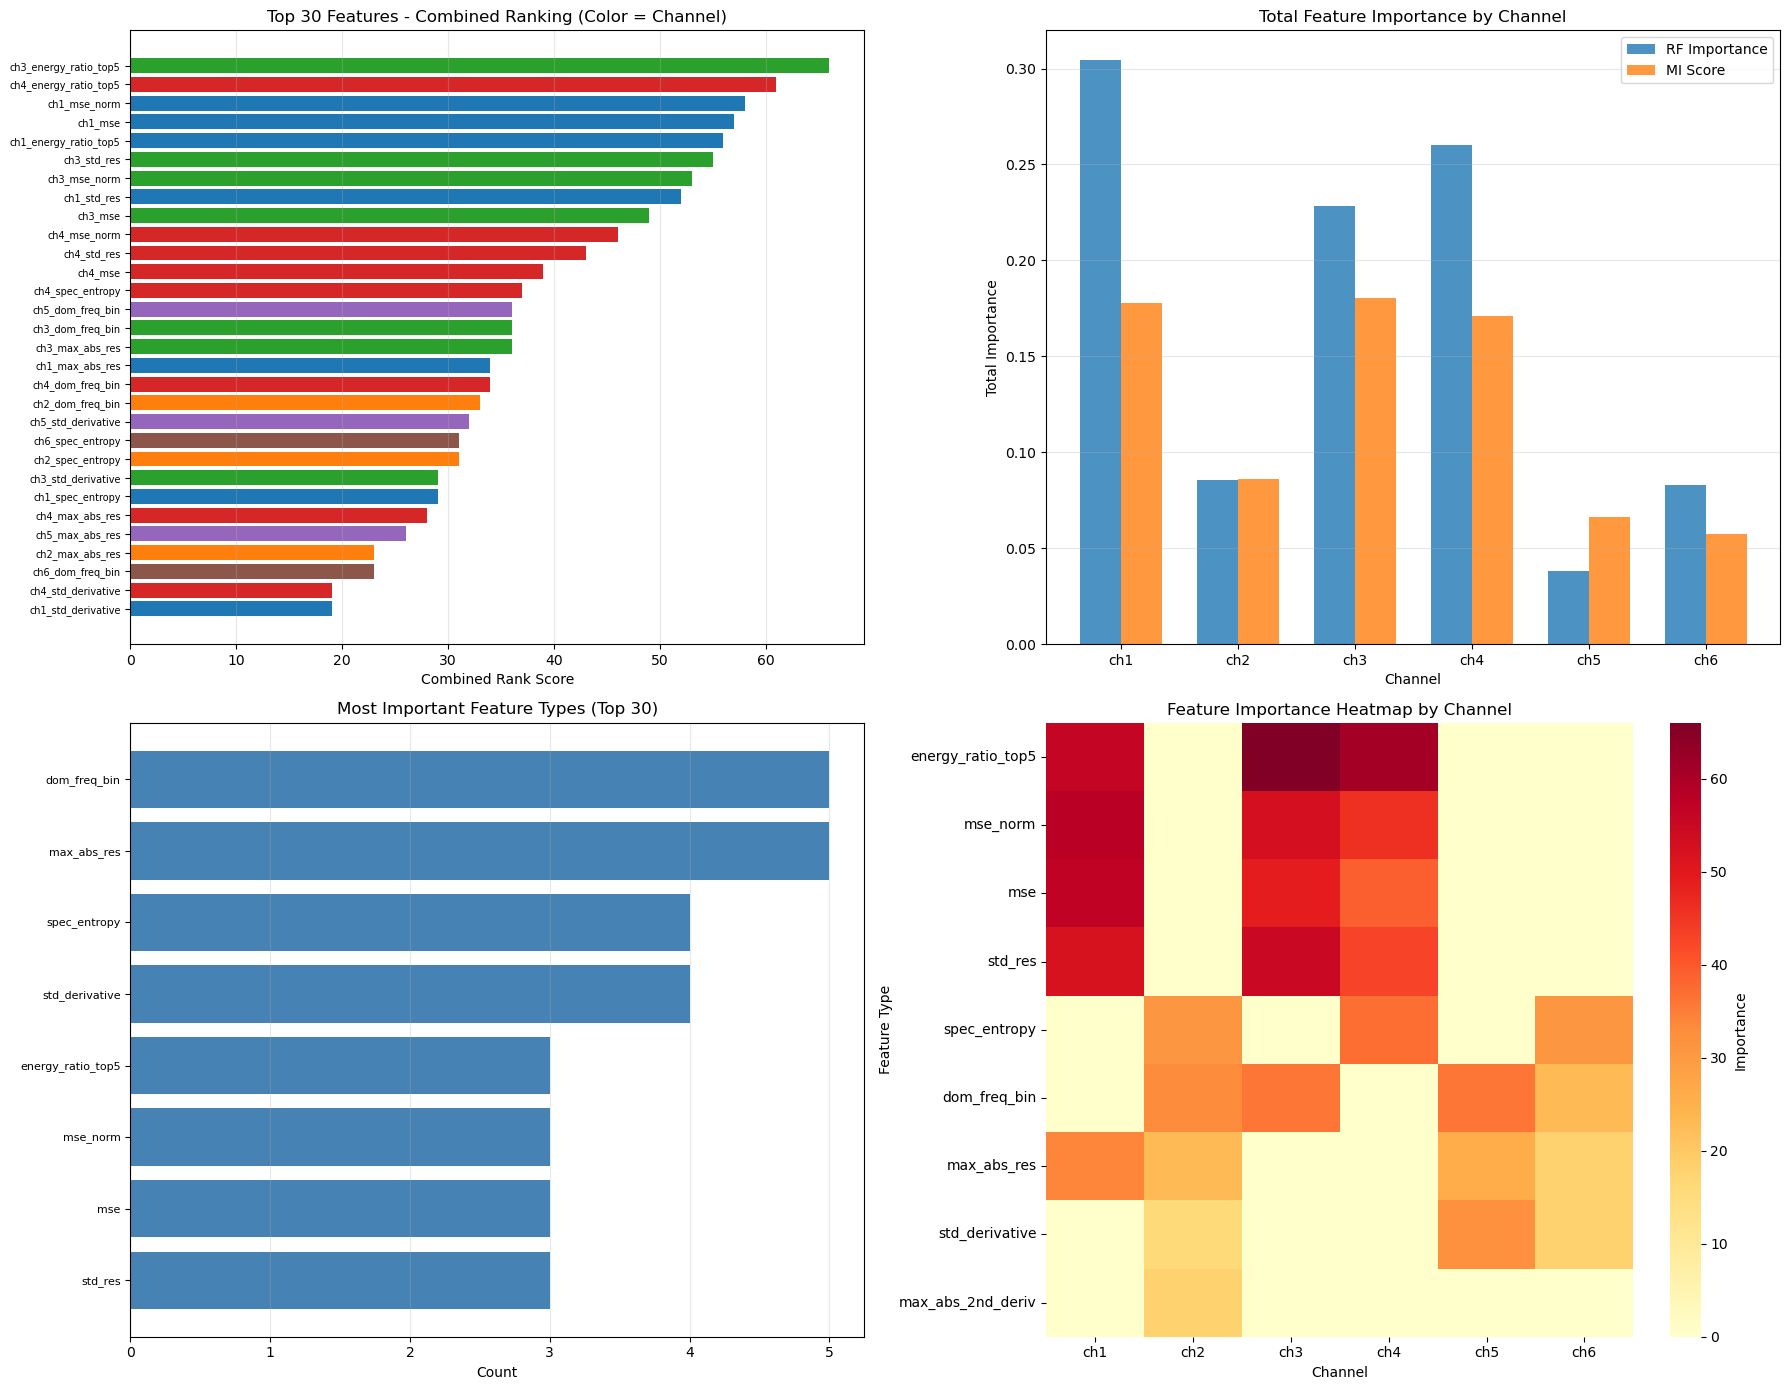

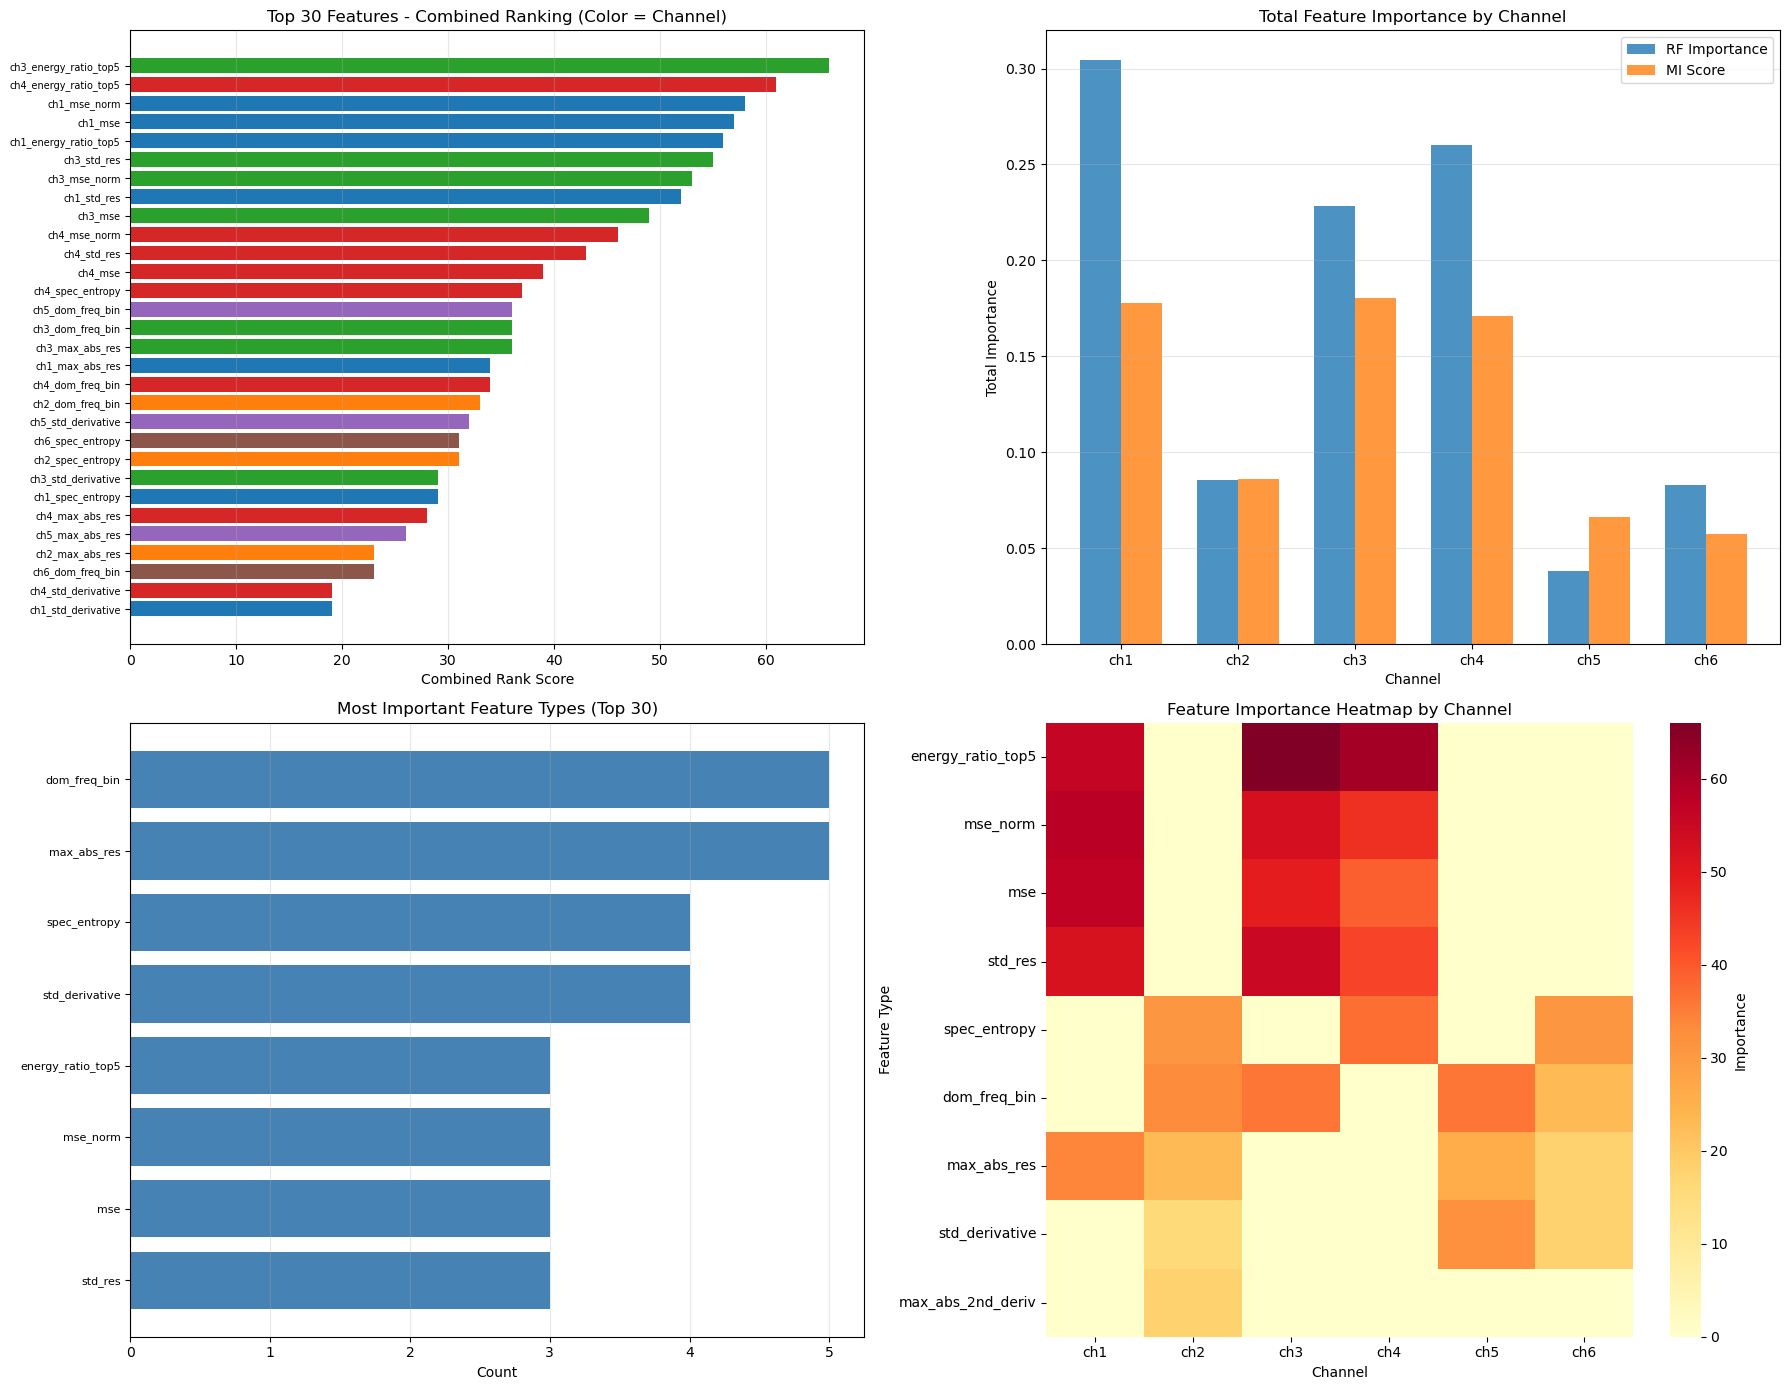

In [71]:
visualize_feature_importance(importance_df, top_n=n_top_features)

## 6. Create Final Dataset

In [72]:
X_selected = X_reduced[selected_features]
    
print("\n" + "=" * 80)
print("FINAL RESULTS")
print("=" * 80)
print(f"Original features: 66 (11 per channel × 6 channels)")
print(f"After correlation removal: {X_reduced.shape[1]}")
print(f"Final selected features: {X_selected.shape[1]}")
print(f"Reduction: {(1 - X_selected.shape[1]/66)*100:.1f}%")
print(f"\nFinal dataset shapes:")
print(f"  X_selected: {X_selected.shape}")
print(f"  y: {y.shape}")


FINAL RESULTS
Original features: 66 (11 per channel × 6 channels)
After correlation removal: 35
Final selected features: 30
Reduction: 54.5%

Final dataset shapes:
  X_selected: (73640, 30)
  y: (73640,)


# Other stuff (deprecated)

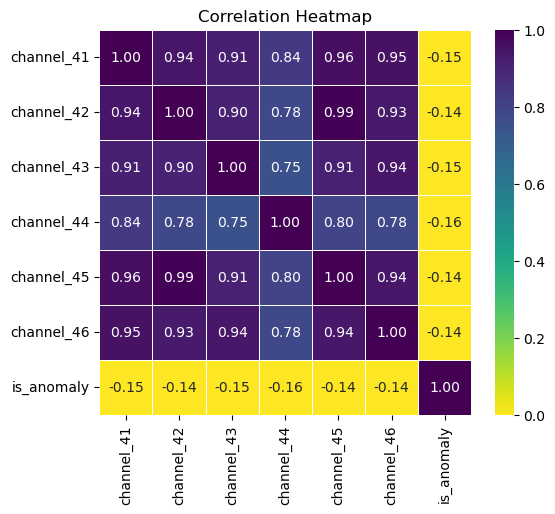

In [ ]:
corr_matrix = df_sample.iloc[:, 1:].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap="viridis_r", vmin = 0, vmax = 1, fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
# Checking skewness of the sample to verify if a log transformation may be applicable
print([skew(i) for i in [Y1, Y2, Y3, Y4, Y5, Y6]])

# All columns are strongly skewed

[-19.987081260812065, -18.801682256835658, -18.834753888827198, -18.605480426360838, -19.573841307386537, -18.489046777296625]


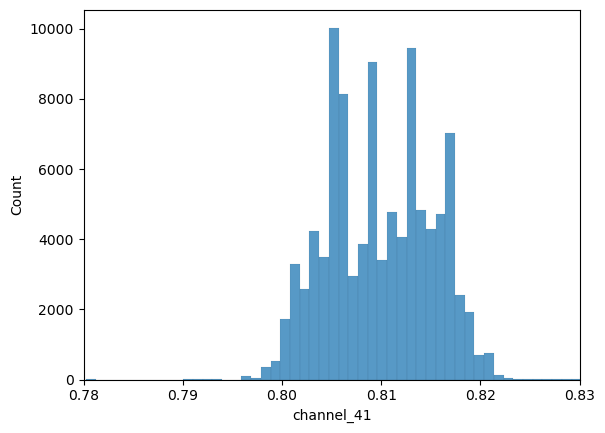

In [ ]:
fig, ax = plt.subplots()
sns.histplot(Y1, bins=1000, ax = ax)
ax.set_xlim(0.78, 0.83)
plt.show()

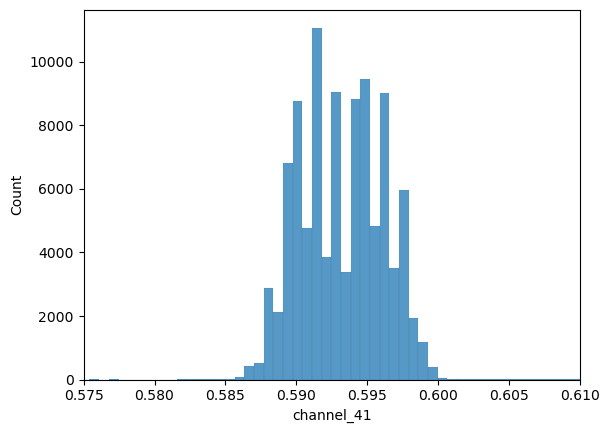

In [ ]:
[Y1log, Y2log, Y3log, Y4log, Y5log, Y6log]  = [np.log(i+1) for i in [Y1, Y2, Y3, Y4, Y5, Y6]]

Y1log.replace([np.inf, -np.inf], np.nan, inplace=True)
Y1log.dropna(inplace=True)

fig, ax = plt.subplots()
sns.histplot(Y1log, bins=1000, ax = ax)
ax.set_xlim(0.575, 0.610)
plt.show()

In [ ]:
skew(Y1log)

-22.32449048825499

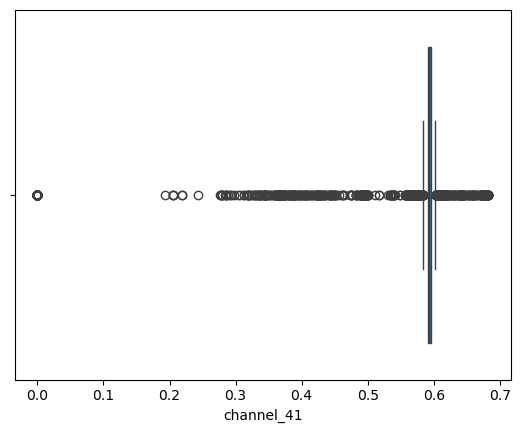

In [ ]:
sns.boxplot(x=Y1log)
plt.show()

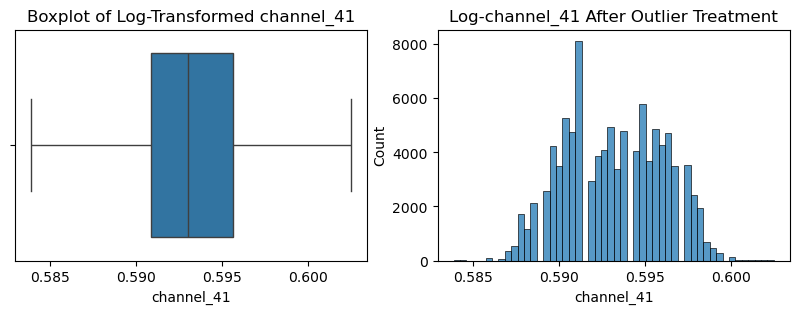

In [ ]:
# Outlier removal - After Log Tranform 

Q1 = Y1log.quantile(0.25)
Q3 = Y1log.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = Y1log[(Y1log < lower_bound) | (Y1log > upper_bound)]

Y1log_clean = Y1log[(Y1log >= lower_bound) & (Y1log <= upper_bound)]

fig, ax = plt.subplots(1, 2)

fig.set_figheight(3)
fig.set_figwidth(10)


sns.boxplot(x=Y1log_clean, ax=ax[0])
ax[0].set_title("Boxplot of Log-Transformed channel_41")

sns.histplot(Y1log_clean, bins=50, ax=ax[1])
ax[1].set_title("Log-channel_41 After Outlier Treatment")

plt.show()

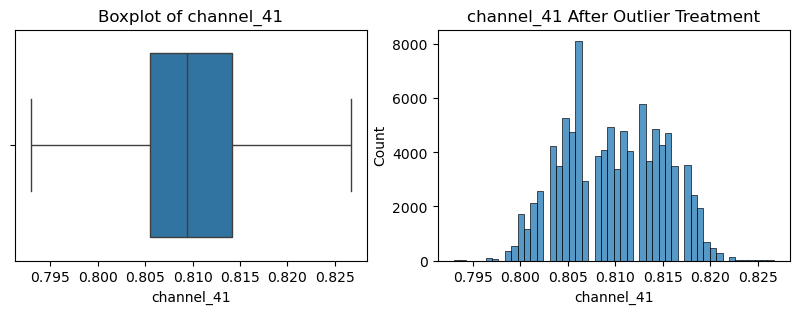

In [ ]:
# Outlier removal - No Log Tranform 

Q1 = Y1.quantile(0.25)
Q3 = Y1.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = Y1[(Y1 < lower_bound) | (Y1 > upper_bound)]

Y1_clean = Y1[(Y1 >= lower_bound) & (Y1 <= upper_bound)]

fig, ax = plt.subplots(1, 2)

fig.set_figheight(3)
fig.set_figwidth(10)


sns.boxplot(x=Y1_clean, ax=ax[0])
ax[0].set_title("Boxplot of channel_41")

sns.histplot(Y1_clean, bins=50, ax=ax[1])
ax[1].set_title("channel_41 After Outlier Treatment")

plt.show()

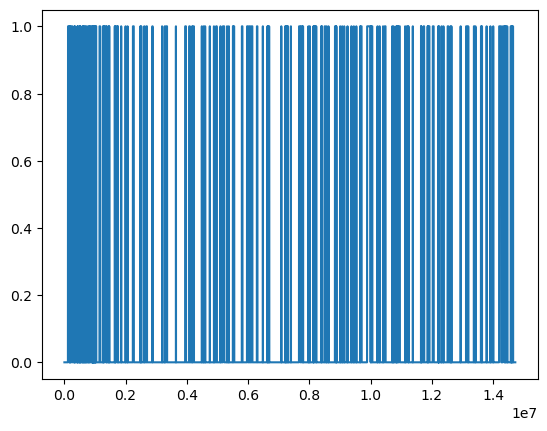

In [ ]:
# Plot anomalies to visualize the data

X = np.array(df_train_4146['id'])
y = np.array(df_train_4146['is_anomaly'])

plt.plot(X, y)

In [ ]:
X = np.array(sample_df_train['id'])
y = np.array(sample_df_train['is_anomaly'])

plt.plot(X, y)

NameError: name 'sample_df_train' is not defined

In [ ]:
reducer = umap.UMAP()

In [ ]:
df_train_data = sample_df_train[
    [
        "channel_41",
        "channel_42",
        "channel_43",
        "channel_44",
        "channel_45",
        "channel_46"
    ]
].values

scaled_df_train_data = StandardScaler().fit_transform(df_train_data)

In [ ]:
scaled_df_train_data.shape

(50000, 6)

In [ ]:
embedding = umap.UMAP().fit_transform(scaled_df_train_data)
embedding.shape

c:\Users\icaro\anaconda3\envs\esa-anomaly-challenge_env\Lib\site-packages\umap\spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


(50000, 2)

Text(0.5, 1.0, 'UMAP projection of the anomaly dataset')

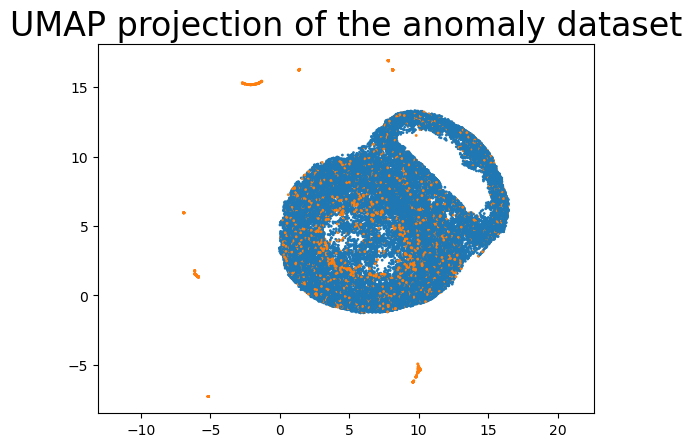

In [ ]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in sample_df_train["is_anomaly"].map({0:0, 1:1})],
    s=1
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the anomaly dataset', fontsize=24)

In [ ]:
df_train_4146['is_anomaly'].value_counts().get(0, 0)

13184217